# SSN algorytm wstecznej propagacji błędów

Imię i nazwisko: Marcin Bobiński

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification # generacja danych

## Generacja danych

Problem klasyfikacji binarnej (kropka żółta czy fioletowa?) dla trzech zmiennych wejściowych $x_1$, $x_2$, $x_3$

In [2]:
m = 300
data = make_classification(n_samples=m, n_features=3, n_informative=3, n_redundant=0, n_classes=2, random_state=0)

In [3]:
X = data[0]
Y = data[1]

In [4]:
X.shape

(300, 3)

In [5]:
Y.shape

(300,)

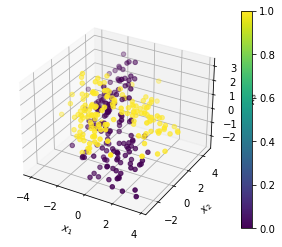

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y.transpose())
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(cax)
plt.show()

# Sieć neuronowa

$$ 
\begin{bmatrix}
w_{11}^{[1]} & w_{12}^{[1]}  & w_{13}^{[1]}\\
\vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots \\
w_{41}^{[1]} & w_{42}^{[1]}  & w_{43}^{[1]}
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
+
\begin{bmatrix}
b_1^{[1]} \\
b_2^{[1]} \\
b_3^{[1]} \\
b_4^{[1]}
\end{bmatrix}
=
\begin{bmatrix}
z_1^{[1]} \\
z_2^{[1]} \\
z_3^{[1]} \\
z_4^{[1]}
\end{bmatrix}
$$

$$ z^{[1]} = W^{[1]}x + b^{[1]} $$

$$ a^{[1]} = \varphi^{[1]}(z^{[1]}) $$

$$ z^{[2]}  = W^{[2]}a^{[1]} + b^{[2]} $$

$$ a^{[2]} = \varphi^{[2]}(z^{[2]}) $$

#### Incjalizacja wartości wag

In [7]:
np.random.seed(0)

In [8]:
def initialize():
    # wartości W losujemy z rozkładu normalnego o średniej 0 i odchyleniu standardowym 0.1, wartości b ustawiamy na 0
    W1 = np.random.normal(0, 0.1, size=(10, 3)) # 10 neuronów
    b1 = np.zeros(shape=(10, 1))
    W2 = np.random.normal(0, 0.1, size=(1, 10)) # 1 neuron wyjściowy
    b2 = np.zeros(shape=(1, 1))
    return W1, b1, W2, b2

In [9]:
W1, b1, W2, b2 = initialize()

In [10]:
print('W1 = ', W1)
print('b1 = ', b1)
print('W2 = ', W2)
print('b2 = ', b2)

W1 =  [[ 0.17640523  0.04001572  0.0978738 ]
 [ 0.22408932  0.1867558  -0.09772779]
 [ 0.09500884 -0.01513572 -0.01032189]
 [ 0.04105985  0.01440436  0.14542735]
 [ 0.07610377  0.0121675   0.04438632]
 [ 0.03336743  0.14940791 -0.02051583]
 [ 0.03130677 -0.08540957 -0.25529898]
 [ 0.06536186  0.08644362 -0.0742165 ]
 [ 0.22697546 -0.14543657  0.00457585]
 [-0.01871839  0.15327792  0.14693588]]
b1 =  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 =  [[ 0.01549474  0.03781625 -0.08877857 -0.19807965 -0.03479121  0.0156349
   0.12302907  0.12023798 -0.03873268 -0.03023028]]
b2 =  [[0.]]


### Funkcje aktywacji

In [11]:
import math

def sigmoid(Z):
    # sigmoidalna funkcja aktywacji dla macierzy Z
    result = np.copy(Z)
    result = result.astype('float64')
    for ix,iy in np.ndindex(result.shape):
        result[ix,iy] = 1/(1+math.exp(-result[ix,iy]))
    return result

def leaky_relu(Z):
    # funkcja aktywacji leaky relu dla macierzy Z (leaky_relu(Z) = max(0.01 * Z, Z))
    result = np.copy(Z)
    result = result.astype('float64')
    result = np.where(result<0, 0.01*result, result)
    return result

def leaky_relu_grad(Z):
    # pochodna funkcji leaky relu dla macierzy Z
    result = np.copy(Z)
    result = result.astype('float64')
    result = np.where(result<0, 0.01, 1)
    return result

## Propagacja w przód

Wektoryzacja dla wielu przykładów

$$ X = \begin{bmatrix}
x_1 ^{(1)} & x_1 ^{(2)} & \dots & x_1 ^{(m)}\\
x_2 ^{(1)} & x_2 ^{(2)} & \dots & x_2 ^{(m)}\\
x_3 ^{(1)} & x_3 ^{(2)} & \dots & x_3 ^{(m)}
\end{bmatrix} $$

$$ Z^{[1]} =  W^{[1]}X + b^{[1]}  $$
$$ A^{[1]} = \varphi^{[1]}(Z^{[1]}) $$
$$ Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]}  $$
$$ A^{[2]} = \varphi^{[2]}(Z^{[2]}) $$
$$ \hat{Y} = A^{[2]} $$

In [12]:
Xt = X.transpose()

In [13]:
Y = Y.reshape(1, m)

In [14]:
def forward(X, W1, W2, b1, b2):
    # wyznaczamy wyjście sieci i wartości w warstwach ukrytych
    Z1 = np.dot(W1, X) + b1
    A1 = leaky_relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Y_hat = A2
    return Z1, A1, Z2, A2, Y_hat

In [15]:
Z1, A1, Z2, A2, Y_hat = forward(Xt, W1, W2, b1, b2)

### Funkcja kosztu

Dla klasyfikacji binarnej stosujemy entropię krzyżową
$$ -\frac{1}{m} \sum_{i=1}^m \left( y_i \log(\hat{y}_i) + (1 - y_i)\log(1-\hat{y}_i)\right) $$

In [16]:
def J(Y, Y_hat):
    # binarna entropia krzyżowa
    result = 0.0
    for i in range(Y.shape[1]): 
        result += Y[0][i] * np.log(Y_hat[0][i]) + (1-Y[0][i])*np.log(1-Y_hat[0][i])
    result /= -Y.shape[1]

    return result# TODO

## Wyznaczanie pochodnych metodą wstecznej propagacji błędów

$$ \frac{\partial J}{\partial Z^{[2]}} = A^{[2]} - Y$$<br>
$$ \frac{\partial J}{\partial W^{[2]}} =\frac{1}{m} \frac{dJ}{\partial Z^{[2]}} A^{[1]T} $$<br>
$$ \frac{\partial J}{\partial b^{[2]}} = \frac{1}{m} np.sum(\frac{dJ}{\partial Z^{[2]}}, axis = 1, keepdims=True) $$<br>
$$\frac{dJ}{\partial Z^{[1]}} = W^{[2]T}\frac{dJ}{\partial Z^{[2]}} * \varphi^{[1]{\prime}}(z_1)$$<br>

$$ \frac{\partial J}{\partial W^{[1]}} = \frac{dJ}{\partial Z^{[1]}} X^T $$<br>
$$ \frac{\partial J}{\partial b^{[1]}} = \frac{1}{m} np.sum(\frac{dJ}{\partial Z^{[1]}}, axis = 1, keepdims=True) $$<br>

In [17]:
def calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, X, m):
    dZ2 = A2 - Y
    dW2 = (1.0/m) * np.dot(dZ2, A1.transpose())
    db2 = (1.0/m) * np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.dot(W2.transpose(),dZ2) * leaky_relu_grad(Z1)
    dW1 = np.dot(dZ1,X.transpose())
    db1 = (1.0/m) * np.sum(dZ1,axis=1,keepdims=True)
    return dW2, db2, dW1, db1

In [18]:
dW2, db2, dW1, db1 = calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, Xt, m)

## Algorytm największego spadku gradientu

1. Przypisz wagom losowe wartości początkowe
2. Wyznacz wyjście sieci $\hat{Y}$
3. Wyznacz wartość funkcji kosztu $J$ 
4. $$ dW = \frac{\partial J}{\partial W} \qquad db = \frac{\partial J}{\partial w}$$
$$ W = W - \alpha dW $$
$$ b = b - \alpha db $$
5. dopóki nie warunek stopu idź do 2

In [19]:
def update(W2, W1, b2, b1, dW2, dW1, db2, db1, alpha=0.001):
    W2 = W2 - alpha * dW2
    W1 = W1 - alpha * dW1
    b2 = b2 - alpha * db2
    b1 = b1 - alpha * db1
    return W2, W1, b2, b1

In [20]:
W2, W1, b2, b1 = update(W2, W1, b2, b1, dW2, dW1, db2, db1)

### Dokładność

Wyjściem sieci jest liczba z zakresu 0-1. Dla $\hat{y}^{(i)} > 0.5$ przewidujemy 1 dla pozostałych 0.
Dokładność (accuracy) jest procentem przykładów, które zostały przewidziane przez sieć prawidłowo (dla których $\hat{y}^{(i)} = y^{(i)}$)

In [21]:
def accuracy(Y, Y_hat):
    result = 0.0
    for i in range(Y.shape[1]):
        if((Y[0][i]==0 and Y_hat[0][i]<=0.5) or (Y[0][i]==1 and Y_hat[0][i]>0.5)):
            result+=1
    
    result /=Y.shape[1]
    result *=100
    return result

Uczenie sieci

In [22]:
# inicjalizacja wag
W1, b1, W2, b2 = initialize()
# lista do zapisu wartości funkcji kosztu w kolejnych krokach uczenia
J_history = []
# lista do zapisu dokładności w kolejnych krokach
acc_history =[]
for i in range(100000):
    Z1, A1, Z2, A2, Y_hat = forward(Xt, W1, W2, b1, b2)
    J_history.append(J(Y, Y_hat))
    acc_history.append(accuracy(Y, Y_hat))
    dW2, db2, dW1, db1 = calculate_gradients(Y, A2, A1, Z1, W2, W1, b2, b1, Xt, m)
    W2, W1, b2, b1 = update(W2, W1, b2, b1, dW2, dW1, db2, db1, alpha=0.001)

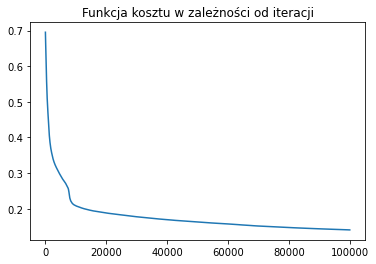

In [23]:
plt.plot(J_history)
plt.title('Funkcja kosztu w zależności od iteracji')
plt.show()

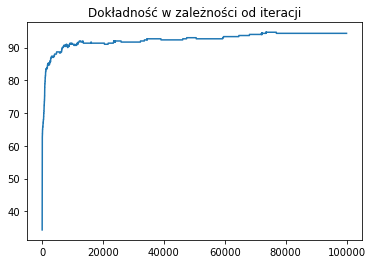

In [24]:
plt.plot(acc_history)
plt.title('Dokładność w zależności od iteracji')
plt.show()

In [25]:
# dokładność na koniec
acc_history[-1]

94.33333333333334

### Predykcja dla nowych danych

In [26]:
# punkt do sprawdzenia
x_test1 = np.array([[3, 3, 0]])

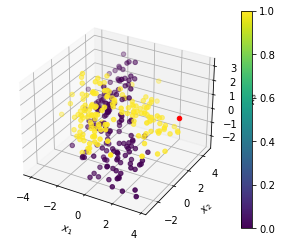

In [27]:
# nowy punkt zaznaczony czerwoną kropką
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(X[:,0], X[:,1], X[:,2], c=Y.reshape(m,))
ax.scatter(x_test1[0][0], x_test1[0][1], x_test1[0][2], c='r')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
fig.colorbar(cax)
plt.show()

In [28]:
# predykacja bliska 1 oznacza żółtą kropkę, bliska 0 fioletową kropkę
Z1, A1, Z2, A2, Y_hat = forward(x_test1.transpose(), W1, W2, b1, b2)
print(Y_hat)

[[0.99994612]]
